<center><strong><h1> <div class="top_section">SENTIMENT ANALYSIS with Transformers</div></h1></strong></center>

## Project [GitHub](https://github.com/NLP-Projects-CAP6640/script3.git)

## [Link](https://drive.google.com/drive/folders/1BurJpXrSnrslqzq9d4gxAZ9yZLzaWI0k?usp=sharing) To Our Model Weights After Traning and Dataset Google Drive

In [1]:
#@title Main Imports for Functionality

import os
import re

from typing import Union, List
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

import pandas as pd
from wordcloud import WordCloud
import seaborn as sns

import string
from collections import Counter, defaultdict

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import random
from pathlib import Path
import json
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir("/content/drive/MyDrive/NLP/")

In [ ]:
#@title Aquire and convert sentiement to integers
data_all = pd.read_excel('/content/drive/MyDrive/NLP/IMDB Dataset.xlsx')

# # splitting dataframe by row index
# set_validate = data_all.iloc[:5000,:]
# set_training = data_all.iloc[5000:,:]
# print("Shape of new dataframes - {} , {}".format(set_validate.shape, set_training.shape))

# prepare Training set and view first 3 entries
sentiement_list = list(data_all["sentiment"])
sentiement_binary = []

for item in sentiement_list:
  if item == "positive":
    sentiement_binary.append(1)
  else:
    sentiement_binary.append(0)

sentiement_list = list(data_all["sentiment"])

data_all["label"] = sentiement_binary
data_all.drop(["sentiment"], inplace=True, axis=1)

print(data_all.sample(3))
print(" ")

# # prepare Validation set and view first 3 entries
# set_validate.drop(["sentiment"], inplace=True, axis=1)

# print(set_validate.sample(3))
# print(" ")

                                                  review  label
17143  The Hollow is a wonderful murder mystery that ...      1
29274  One of the best records of Israel's response t...      1
9292   This film revolves as much around Japanese cul...      1
 


<a id="eda"></a>
<strong><center><h1><div class="top_section">2. EDA</div></h1></center></strong>


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords_nltk = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Check GPU avalibility Stuff

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:

# Text preprocessing

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r'  ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n]<br /><br />)', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()

    return s

In [4]:
data_all = pd.read_excel('/content/drive/MyDrive/NLP/data_all.xlsx')

In [5]:
data_all.head()

,label,review2
0,1,one reviewers mentioned watching 1 oz episode ...
1,1,wonderful little production br br filming tech...
2,1,thought wonderful way spend time hot summer we...
3,0,basically family little boy jake thinks zombie...
4,1,petter mattei love time money visually stunnin...


In [ ]:
# basic info
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    50000 non-null  int64 
 1   review2  50000 non-null  object
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [ ]:
# Preprocess text
data_all['review2'] = ([text_preprocessing(text) for text in data_all['review']])


In [ ]:
data_all.drop(["review"], inplace=True, axis=1)

In [ ]:
data_all.to_excel('/content/drive/MyDrive/NLP/data_all.xlsx', index=False)

<a id="visualizations"></a>


<strong><h1>Visualizations</h1></strong>

<a id="word_cloud"></a>

## Word Cloud



In [ ]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=100,
        max_font_size=40,
        scale=1,
        random_state=1
).generate(" ".join(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

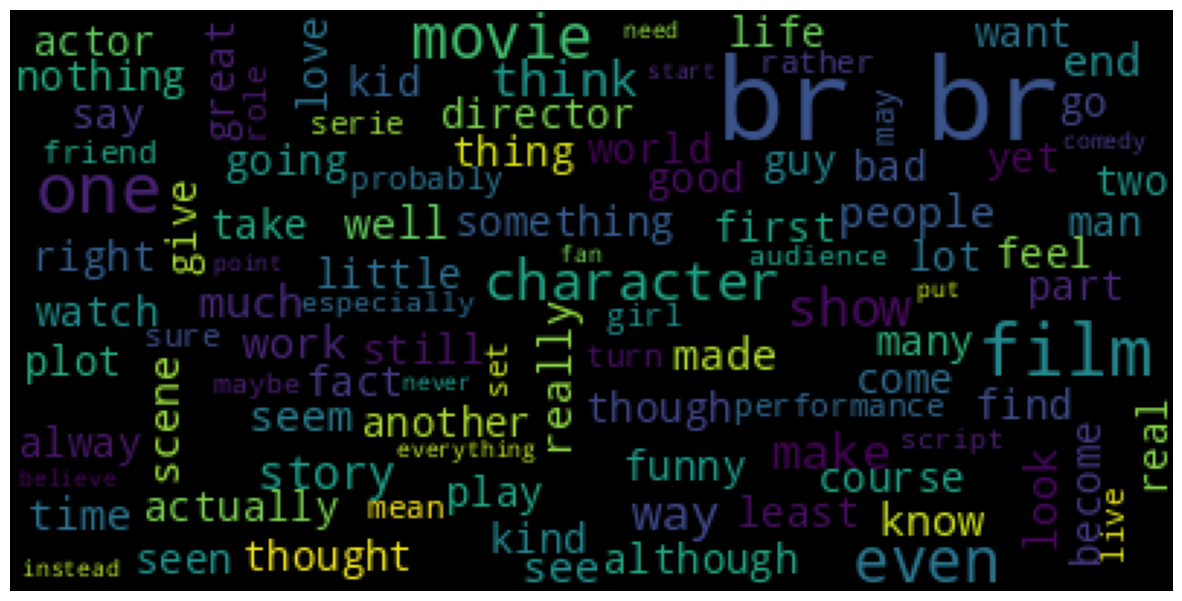

In [ ]:
show_wordcloud(data_all["review2"])

In [ ]:
data_all.head()

,label,review2
0,1,one reviewers mentioned watching 1 oz episode ...
1,1,wonderful little production br br filming tech...
2,1,thought wonderful way spend time hot summer we...
3,0,basically family little boy jake thinks zombie...
4,1,petter mattei love time money visually stunnin...


<a id="target_count"></a>

## Counts of labesl in training data



In [ ]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "bar"}]])
colors = ['pink', 'blue'] #
fig.add_trace(go.Pie(labels=data_all.label.value_counts().index,
                             values=data_all.label.value_counts().values), 1, 1)

fig.update_traces(hoverinfo='label+percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.add_trace(go.Bar(x=data_all.label.value_counts().index, y=data_all.label.value_counts().values, marker_color = colors), 1,2)

fig.show()


<a id="token_counts_with_BERT_tokenizer"></a>

## BERT tokenizer



In [6]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
# data tokenize with bert tokenizer
data_all["Token_length"] = data_all["review2"].apply(lambda x: len(tokenizer(x, add_special_tokens=False)["input_ids"]))

Token indices sequence length is longer than the specified maximum sequence length for this model (582 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
fig = px.histogram(data_all, x="Token_length", nbins=20, color_discrete_sequence=px.colors.cmocean.algae, barmode='group', histnorm="percent")
fig.show()

<a id="characters_count_in_the_data"></a>

## Characters Count in the Data

**Let's look at the frequency of the number of characters. It will give us information about the overall size of our data**

In [ ]:
# valvulate char count for each review
data_all['char_count'] = data_all['review2'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature):
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 )
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))




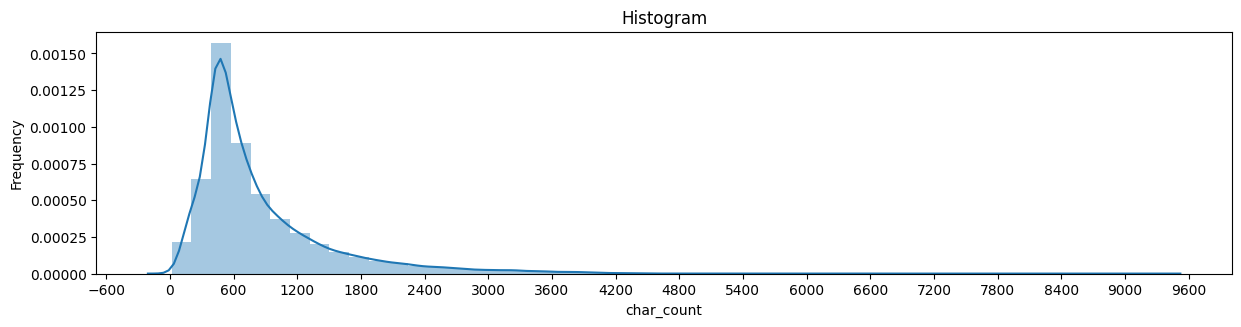

In [ ]:
plot_dist3(data_all, 'char_count')

<a id="reviews_lengths"></a>

## Reviews Lengths




In [8]:
# Creating a new feature for the visualization.
data_all['Character Count'] = data_all['review2'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(24, 12))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))


    ax2 = fig.add_subplot(grid[1, :2])

    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    plt.suptitle(f'{title}', fontsize=24)

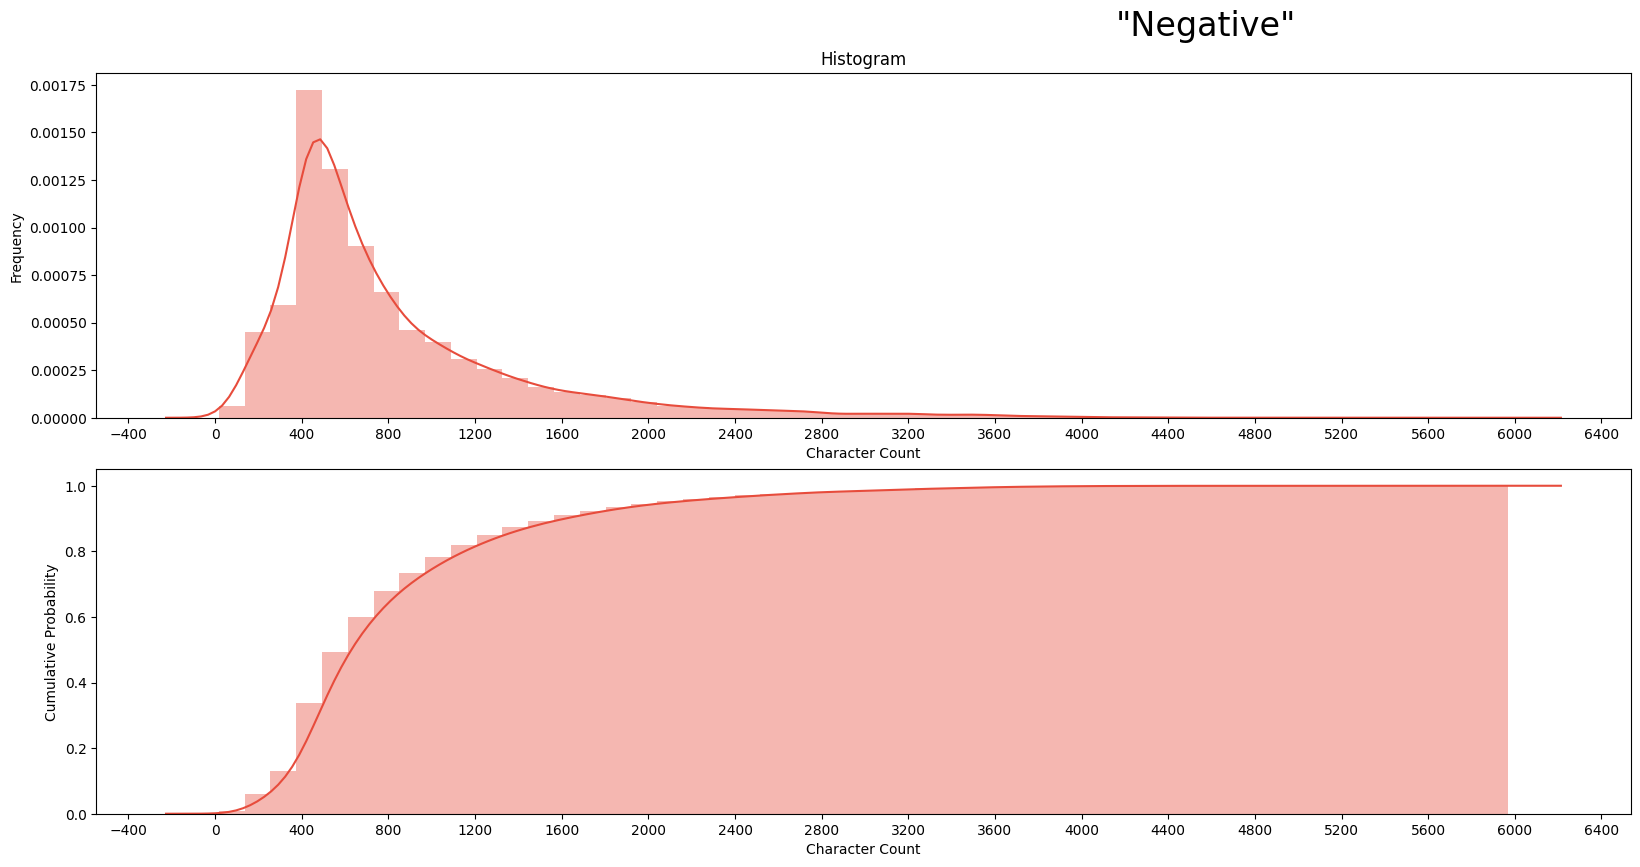

In [ ]:
plot_dist3(data_all[data_all['label'] == 0], 'Character Count',
           '"Negative"')

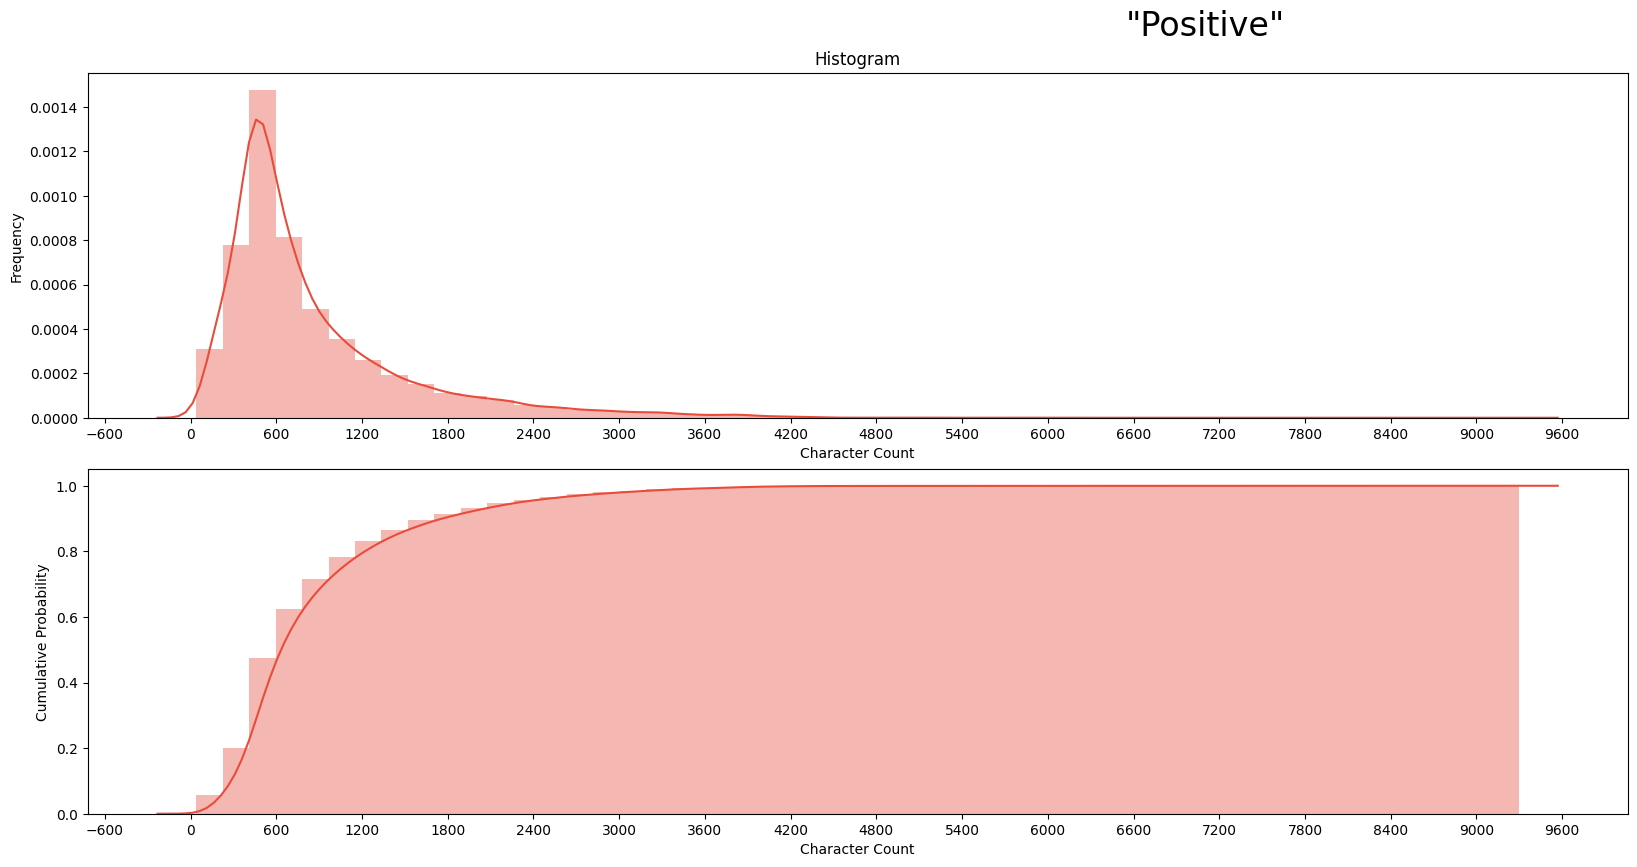

In [ ]:
plot_dist3(data_all[data_all['label'] == 1], 'Character Count',
           '"Positive"')

<a id="word_counts"></a>

## Word Counts




In [ ]:
def plot_word_number_histogram(textno, textye):

    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(18, 12), sharey=True)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')



    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('negative')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('positive')

    fig.suptitle('Words Per Review', fontsize=24, va='baseline')

    fig.tight_layout()

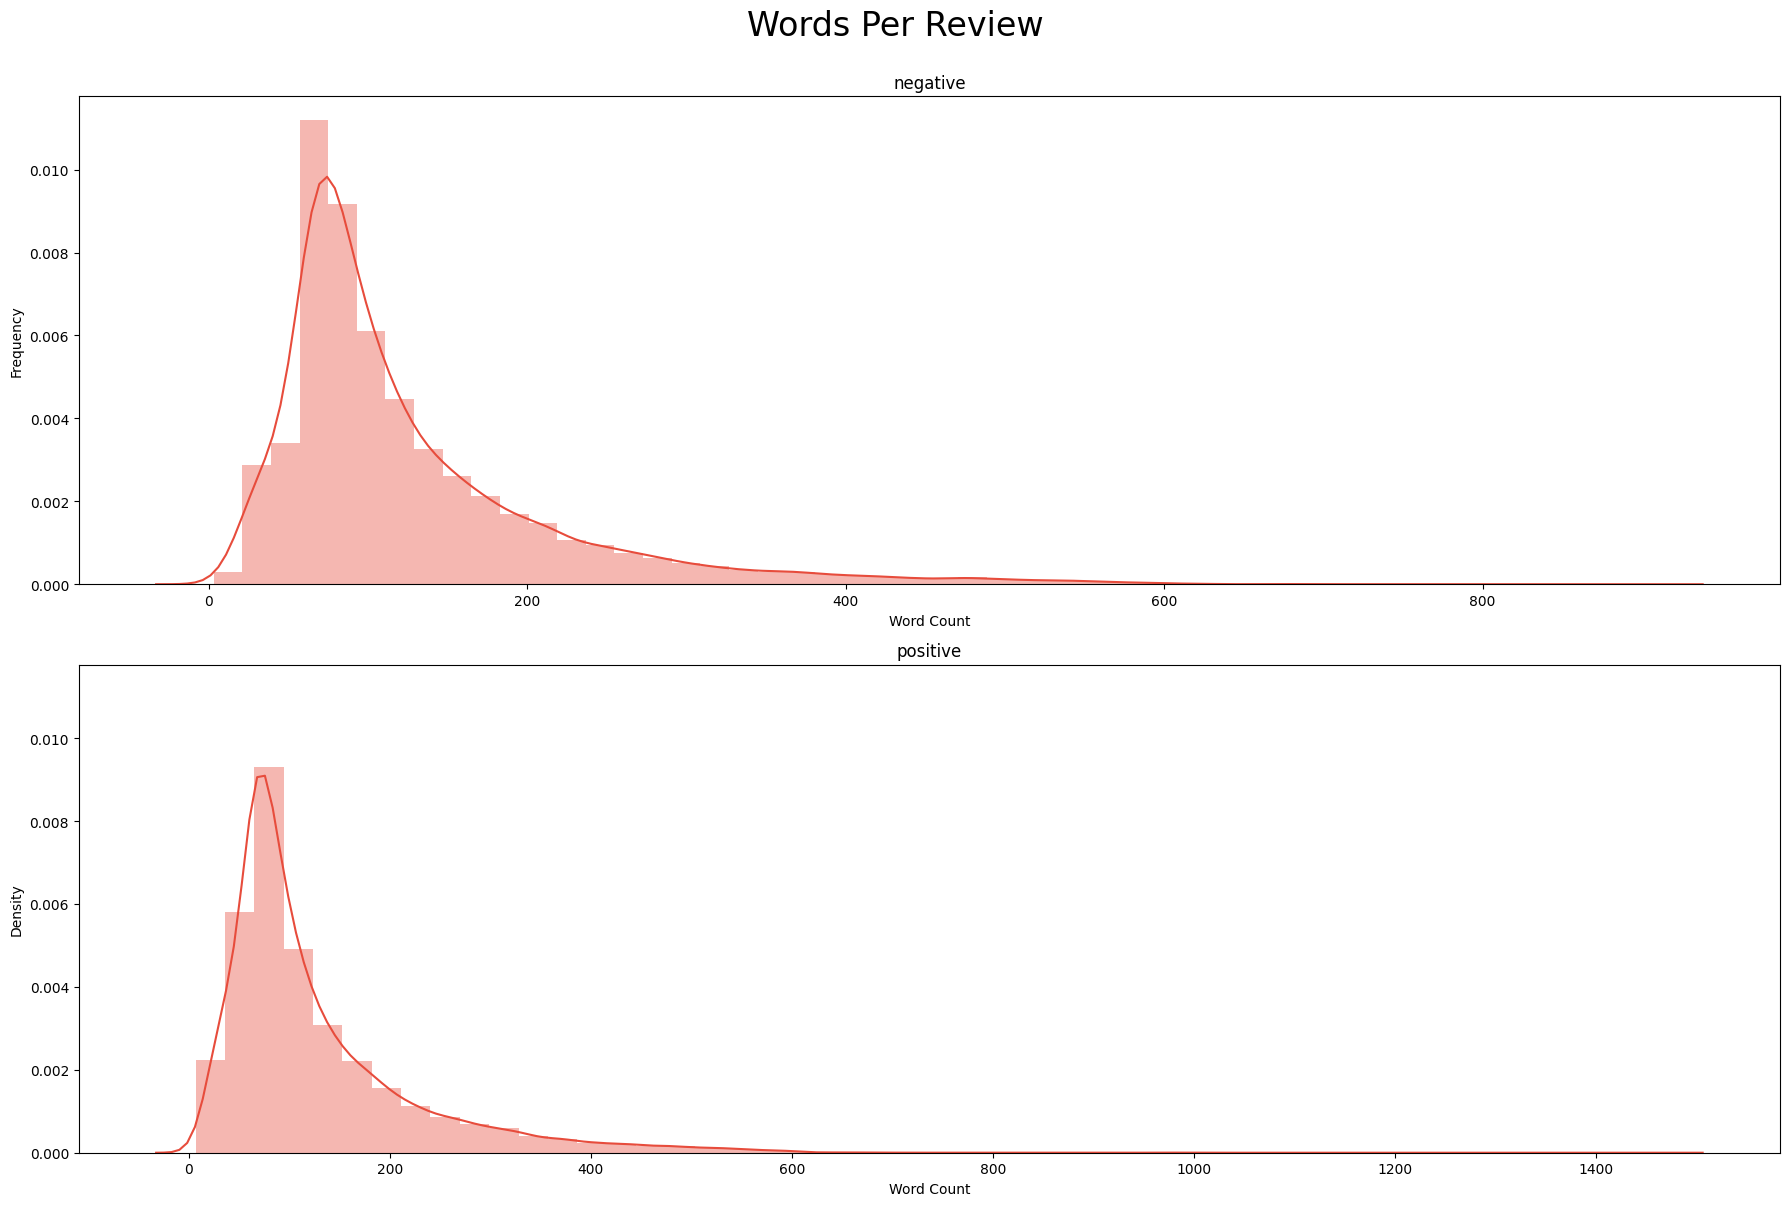

In [ ]:
plot_word_number_histogram(data_all[data_all['label'] == 0]['review2'],
                           data_all[data_all['label'] == 1]['review2'] )

<a id="most_common_words"></a>
## Most Common Words

In [ ]:
texts = data_all['review2']
new = texts.str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]
counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word, count in most[:30]:
    if word not in stopWords_nltk:
        x.append(word)
        y.append(count)

fig = go.Figure(go.Bar(
            x=y,
            y=x,
            orientation='h',  marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='Most common Word',))

fig.update_layout( title={
        'text': "Most Common Words",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ))

fig.show()

<a id="most_common_ngrams"></a>

## Most Common ngrams

In [ ]:
fig = make_subplots(rows=1, cols=2)
title_ = ["negative", "positive"]

for i in range(2):
    texts = data_all['review2']
    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []

    for word, count in most[:30]:
        if word not in stopWords_nltk:
            x.append(word)
            y.append(count)

    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1)

fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common ngrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        size=24,
        color="RebeccaPurple"
        )
    ),)


fig.show()

In [ ]:
data_all.head()

,label,review2,char_count,Token_length
0,1,one reviewers mentioned watching 1 oz episode ...,1151,193
1,1,wonderful little production br br filming tech...,686,107
2,1,thought wonderful way spend time hot summer we...,594,98
3,0,basically family little boy jake thinks zombie...,456,80
4,1,petter mattei love time money visually stunnin...,880,153


In [ ]:
def _get_top_ngram(corpus, n=None):
    #getting top ngrams
    vec = CountVectorizer(ngram_range=(n, n),
                          max_df=0.9,
                          ).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:15]

In [ ]:
# unigram
fig = make_subplots(rows=1, cols=2)

title_ = ["negative",  "positive"]

for i in range(2):
    texts = data_all[data_all["label"] == i]['review2']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    top_n_bigrams = _get_top_ngram(texts, 2)[:15]
    x, y = map(list, zip(*top_n_bigrams))


    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1)


fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common unigrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ))
fig.show()

In [ ]:
#trigram

fig = make_subplots(rows=1, cols=2)
title_ = ["negative","positive"]

for i in range(2):
    texts = data_all[data_all["label"] == i]['review2']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    top_n_bigrams = _get_top_ngram(texts, 3)[:15]
    x, y = map(list, zip(*top_n_bigrams))

    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1),

fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common trigrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ))

fig.show()

<a id="models"></a>
<strong><center><h1><div class="top_section">Transformer Model</div></h1></center></strong>


<a id="preprocess_for_BERT_Train"></a>

<strong><h1>BERT Train</h1></strong>

In [9]:
class Config():
    seed_val = 17
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    epochs = 1
    batch_size = 6
    seq_length = 512
    lr = 2e-5
    eps = 1e-8
    pretrained_model = 'bert-base-uncased'
    test_size=0.15
    random_state=42
    add_special_tokens=True
    return_attention_mask=True
    pad_to_max_length=True
    do_lower_case=False
    return_tensors='pt'

config = Config()

## Params we will be saving

In [10]:

params = {"seed_val": config.seed_val,
    "device":str(config.device),
    "epochs":config.epochs,
    "batch_size":config.batch_size,
    "seq_length":config.seq_length,
    "lr":config.lr,
    "eps":config.eps,
    "pretrained_model": config.pretrained_model,
    "test_size":config.test_size,
    "random_state":config.random_state,
    "add_special_tokens":config.add_special_tokens,
    "return_attention_mask":config.return_attention_mask,
    "pad_to_max_length":config.pad_to_max_length,
    "do_lower_case":config.do_lower_case,
    "return_tensors":config.return_tensors,
         }

In [11]:
import random

device = config.device

random.seed(config.seed_val)
np.random.seed(config.seed_val)
torch.manual_seed(config.seed_val)
torch.cuda.manual_seed_all(config.seed_val)

<a id="Train_and_Validation_Split"></a>
<strong><h2>Train and Validation Split</h2></strong>


In [12]:

from sklearn.model_selection import train_test_split

train_df, val= train_test_split(data_all,
                                    test_size=0.10,
                                    random_state=config.random_state,
                            stratify=data_all.label.values)

In [13]:
train_df.head()

,label,review2,Token_length,Character Count
14700,0,since little mermaid one favorite disney movie...,211,1334
10733,0,based novel michael chabon mysteries pittsburg...,114,714
30659,0,makes third errol morris movie seen increasing...,232,1465
10987,0,sitting big wing chair huge book lap one bela ...,365,2112
33167,1,kid movie great adult mother enjoyed watching ...,162,1034


In [14]:
val.head()

,label,review2,Token_length,Character Count
30859,1,not kidding summary vote video distributors pa...,268,1595
7217,0,kept waiting film move inspire shock sadden wa...,61,377
34889,0,movie 90 minute ramones concert brief periods ...,55,314
30806,1,every scene put together perfectly movie wonde...,119,741
36408,0,uma travolta good together unfortunately left ...,96,543


In [15]:
train, test = train_test_split(train_df,
                                    test_size=0.10,
                                    random_state=42,
                            stratify=train_df.label.values)

In [16]:
# count of unique label  control
print(len(train['label'].unique()))
print(train.shape)

2
(40500, 4)


In [17]:
# count of unique label  control
print(len(test['label'].unique()))
print(test.shape)

2
(4500, 4)


In [18]:
# count of unique label  control
print(len(val['label'].unique()))
print(val.shape)

2
(5000, 4)


<a id="BertTokenizer_and_Encoding_the1_Data"></a>

<strong><h2>BertTokenizer</h2></strong>

In [19]:
# create tokenizer
tokenizer = BertTokenizer.from_pretrained(config.pretrained_model,
                                          do_lower_case=config.do_lower_case)

In [20]:
encoded_data_train = tokenizer.batch_encode_plus(
    train.review2.values,
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors
)
encoded_data_val = tokenizer.batch_encode_plus(
    val.review2.values,
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [21]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val.label.values)

In [22]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

<a id="Creating_the_Model"></a>

<strong><h2>Creating the Model</h2></strong>

In [23]:
model = BertForSequenceClassification.from_pretrained(config.pretrained_model,
                                                      num_labels=2,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<a id="Data_Loaders"></a>
<strong><h2>Data Loaders</h2></strong>




In [24]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=config.batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=config.batch_size)

<a id="Optimizer_Scheduler"></a>

<strong><h2>Optimizer & Scheduler</h2></strong>

In [25]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=config.lr,
                  eps=config.eps)


scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*config.epochs)

<a id="Performance_Metrics"></a>
<strong><h2>Performance Metrics</h2></strong>

We will use f1 score  as performance metrics.

In [26]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

<a id="Training_Loop"></a>
<strong><h2>Training Loop</h2></strong>

In [27]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(config.device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    # calculate avareage val loss
    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [32]:
config.device

device(type='cuda', index=0)

In [35]:
model.to(config.device)

for epoch in tqdm(range(1, 2)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)

    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(config.device) for b in batch)


        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f'/content/drive/MyDrive/NLP/BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')

    tqdm.write(f'F1 Score (Weighted): {val_f1}');
# save model params and other configs
with Path('/content/drive/MyDrive/NLP/params.json').open("w") as f:
    json.dump(params, f, ensure_ascii=False, indent=4)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/6750 [00:00<?, ?it/s]

KeyboardInterrupt: 

<a id="Test"></a>
<strong><h2>Test on validation set</h2></strong>

In [63]:
model.to(config.device)

model.load_state_dict(torch.load('/content/drive/MyDrive/NLP/BERT_epoch_1.model'))
# device = torch.device("cuda")
# # model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(f'/content/drive/MyDrive/NLP/BERT_epoch_1.model', map_location="cuda:0"))  # Choose whatever GPU device number you want

<All keys matched successfully>

<a id="error_analysis"></a>

<strong><center><h1><div class="top_section">Evaluation</div></h1></center></strong>


In [65]:
pred_final = []

for i, row in tqdm(val.iterrows(), total=val.shape[0]):
    predictions = []

    review = row["review2"]
    encoded_data_test_single = tokenizer.batch_encode_plus(
    [review],
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors
    )
    input_ids_test = encoded_data_test_single['input_ids']
    attention_masks_test = encoded_data_test_single['attention_mask']


    inputs = {'input_ids':      input_ids_test.to(device),
              'attention_mask':attention_masks_test.to(device),
             }

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)
    predictions = np.concatenate(predictions, axis=0)
    pred_final.append(np.argmax(predictions, axis=1).flatten()[0])

  0%|          | 0/429 [00:00<?, ?it/s]

In [66]:
val["pred"] = pred_final

In [70]:
control = val.pred.values == val.label.values
val["control"] = control

In [38]:
#adding prediction col
val["pred"] = pred_final
control = val.pred.values == val.label.values
val["control"] = control

In [39]:
# filtering predictions
val = val[val.control == False]

In [72]:
val = val[val.control == False]

In [73]:

name2label = {"Negative":0,
             "Positive":1
             }
label2name = {v: k for k, v in name2label.items()}

val["pred_name"] = val.pred.apply(lambda x: label2name.get(x))

In [75]:
from sklearn.metrics import confusion_matrix

# We create a confusion matrix to better observe the classes that the model confuses.
pred_name_values = val.pred_name.values
label_values = val.pred_name.values
confmat = confusion_matrix(label_values, pred_name_values, labels=list(name2label.keys()))

In [76]:
confmat

array([[236,   0],
       [  0, 144]])

In [77]:
df_confusion_val = pd.crosstab(label_values, pred_name_values)
df_confusion_val

col_0,Negative,Positive
row_0,,
Negative,236,0
Positive,0,144


In [78]:
df_confusion_val.to_csv("val_df_confusion.csv")

In [80]:
test.head()

,label,review2,Token_length,Character Count,pred,control,pred_name
22601,0,one entertaining flick suggest rent buy couple...,70,428,1,False,Positive
36824,0,2000 came close king kong adopted daughter wen...,165,951,1,False,Positive
48367,1,anatomie certainly one better movies seen not ...,55,338,0,False,Negative
15745,0,ravaged wasteland future mankind terrorized cy...,133,689,1,False,Positive
22034,1,big gone wind nut disappointed gone wind movie...,89,555,0,False,Negative


In [81]:
encoded_data_test = tokenizer.batch_encode_plus(
    test.review2.values,
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors
)

In [82]:
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(test.label.values)

In [83]:
model = BertForSequenceClassification.from_pretrained(config.pretrained_model,
                                                      num_labels=2,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(config.device)

model.load_state_dict(torch.load(f'/content/drive/MyDrive/NLP/BERT_epoch_1.model', map_location=torch.device('cpu')))

_, predictions_test, true_vals_test = evaluate(dataloader_validation)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [84]:
from sklearn.metrics import classification_report

preds_flat_test = np.argmax(predictions_test, axis=1).flatten()
print(classification_report(preds_flat_test, true_vals_test))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      2604
           1       0.90      0.93      0.91      2396

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



In [85]:
pred_final = []

for i, row in tqdm(test.iterrows(), total=test.shape[0]):
    predictions = []

    review = row["review2"]
    encoded_data_test_single = tokenizer.batch_encode_plus(
    [review],
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors
    )
    input_ids_test = encoded_data_test_single['input_ids']
    attention_masks_test = encoded_data_test_single['attention_mask']


    inputs = {'input_ids':      input_ids_test.to(device),
              'attention_mask':attention_masks_test.to(device),
             }

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)
    predictions = np.concatenate(predictions, axis=0)
    pred_final.append(np.argmax(predictions, axis=1).flatten()[0])

  0%|          | 0/375 [00:00<?, ?it/s]

In [86]:
test["pred"] = pred_final
control = test.pred.values == test.label.values
test["control"] = control

In [88]:
test = test[test.control == False]

In [89]:
test["pred_name"] = test.pred.apply(lambda x: label2name.get(x))

In [90]:
from sklearn.metrics import confusion_matrix

# We create a confusion matrix to better observe the classes that the model confuses.
pred_name_values = test.pred_name.values
label_values = test.pred_name.values
confmat = confusion_matrix(label_values, pred_name_values, labels=list(name2label.keys()))



In [92]:
confmat

array([[255,   0],
       [  0, 120]])

In [93]:
df_confusion_test = pd.crosstab(label_values, pred_name_values)
df_confusion_test

col_0,Negative,Positive
row_0,,
Negative,255,0
Positive,0,120


In [59]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
pandoc set to manually installed.
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  fonts-urw-base35 libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6
  libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby ruby-net-telnet ruby-rubygems
  ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils teckit tex-common tex-gyre
  texlive-base texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fo

In [98]:
!jupyter nbconvert --to PDF "Scrip3.ipynb"

[NbConvertApp] Converting notebook Scrip3.ipynb to PDF
/usr/local/lib/python3.10/dist-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['text/html']) is not able to be represented.
  warn(
/usr/local/lib/python3.10/dist-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['text/html']) is not able to be represented.
  warn(
/usr/local/lib/python3.10/dist-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['text/html']) is not able to be represented.
  warn(
/usr/local/lib/python3.10/dist-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['text/html']) is not able to be represented.
  warn(
[NbConvertApp] Support files will be in Scrip3_files/
[NbConvertApp] Making directory ./Scrip3_files
[NbConvertApp] Making directory ./Scrip3_files
[NbConvertApp] Making directory ./Scrip3_files
[N

In [ ]:
#CONCLUSIONS

#This project successfully leveraged BERT pre-trained model to perform sentiment analysis on a dataset of movie reviews, categorized into positive and negative sentiments. Through meticulous preprocessing and fine-tuning of the pre-trained model, we tailored it to the complexities of sentiment classification in movie reviews, achieving a model capable of distinguishing between positive and negative reviews with remarkable accuracy.

#The evaluation metrics demonstrates the model's effectiveness in sentiment classification:

#-For negative reviews (label 0), the model achieved a precision of 0.94, recall of 0.90, and F1-score of 0.92.
#-For positive reviews (label 1), the model showed a precision of 0.90, recall of 0.93, and F1-score of 0.91.
#-Overall accuracy stood at 0.92 across the dataset of 5000 reviews.
#-The macro and weighted averages for precision, recall, and F1-score all mirrored the model's robust performance at 0.92, further validating the model's capability in handling both positive and negative sentiments effectively.

#These results are indicative of the model's robustness and its ability to generalize well to unseen movie reviews, affirming the power of pre-trained models in extracting meaningful insights from textual data. The high levels of precision and recall across both classes demonstrate the model's balanced capability in accurately classifying sentiments, making it a valuable tool for analyzing movie reviews.